Number of rows:  1460
Number of columns:  80
Rows with missing target:  0
Rows with missing target:  180921.19589041095


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


AssertionError: Must have at least 1 validation dataset for early stopping.

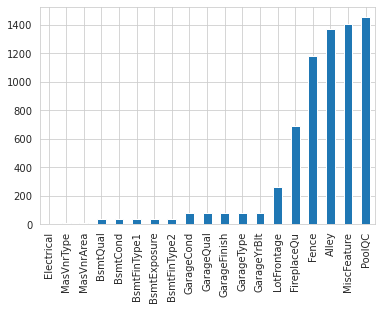

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import seaborn as sns

# Read the data
X_full = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv', index_col='Id')

print("Number of rows: " , X_full.shape[0])
print("Number of columns: " , X_full.shape[1])
print("Rows with missing target: " , X_full['SalePrice'].isna().sum())
print("House mean price: " , X_full['SalePrice'].sum()/X_full.shape[0])

# plotting the missing value for each column
sns.set_style("whitegrid")
missing = X_full.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

# data manipulation and preprocesssing
X_full['MSSubClass'] = X_full['MSSubClass'].apply(str)
X_full['YrSold'] = X_full['YrSold'].astype(str)
X_full['MoSold'] = X_full['MoSold'].astype(str)
X_full['Electrical'] = X_full['Electrical'].fillna("SBrkr") 
X_full['KitchenQual'] = X_full['KitchenQual'].fillna("TA") 
X_full["PoolQC"] = X_full["PoolQC"].fillna("None")

X_full = X_full.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
X_full['YrBltAndRemod']=X_full['YearBuilt']+X_full['YearRemodAdd']
X_full['TotalSF']=X_full['TotalBsmtSF'] + X_full['1stFlrSF'] + X_full['2ndFlrSF']
X_full['Total_sqr_footage'] = (X_full['BsmtFinSF1'] + X_full['BsmtFinSF2'] +
                                X_full['1stFlrSF'] + X_full['2ndFlrSF'])
X_full['Total_porch_sf'] = (X_full['OpenPorchSF'] + X_full['3SsnPorch'] +
                             X_full['EnclosedPorch'] + X_full['ScreenPorch'] +
                             X_full['WoodDeckSF'])
X_full['haspool'] = X_full['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
X_full['has2ndfloor'] = X_full['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
X_full['hasgarage'] = X_full['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
X_full['hasbsmt'] = X_full['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
X_full['hasfireplace'] = X_full['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


# Remove rows with missing target
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)

#separate target from predictors
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)


# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y)

# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)

X_train, X_valid = X_train.align(X_valid, join='left', axis=1)

# Define model  
XGBmodel = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)

#fitting part
XGBmodel.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_train, y_train)],
             verbose=False)

# prediction
preds = XGBmodel.predict(X_valid)
print('MAE XGB:', mean_absolute_error(y_valid, preds))

#MAE XGB: 13973.797024828767

